# *FDDB - Group 3 Mini Project Presentation*

### Team Members

- *Lim Jia Wei Jerald*
- *Maturi Tanusha Lakshmi Ananya*
- *Pandey Shaurya Garg*
- *Satya Nikitha Pulapa*
- *Sua Chin Rong (Cai Zhenrong)*

---


# Problem Statement

The **Introduction to Data Science** course at NTU has reached an enrollment of 6,000 students, organized into 120 tutorial groups. The course coordinator needs an efficient way to form balanced teams of five for a mini-project. 

Given data on each student's **Tutorial Group, School, Gender,** and **CGPA**, the goal is to create an application that ensures diversity in school affiliation, gender, and academic performance, while accommodating potential limitations within each tutorial group.

### Defining Diversity

In this project, **diversity** is defined as ensuring that each group within a tutorial has a consistent and balanced mix of students. This balance is achieved by considering:

- **School Affiliation**: Each group should include students from different schools, ensuring varied knowledge and skills.
- **Gender Representation**: To promote inclusivity, each group should have a balanced gender mix, avoiding any majority of one gender.
- **CGPA Range**: Groups should have a spread of CGPAs to prevent any concentration of high or low academic performers.

The goal is to maintain a **medium level of diversity** across all groups within a tutorial, ensuring that each group is similarly diverse without having a few groups with high diversity and the majority with low diversity.

---


# **Analysis of Data**

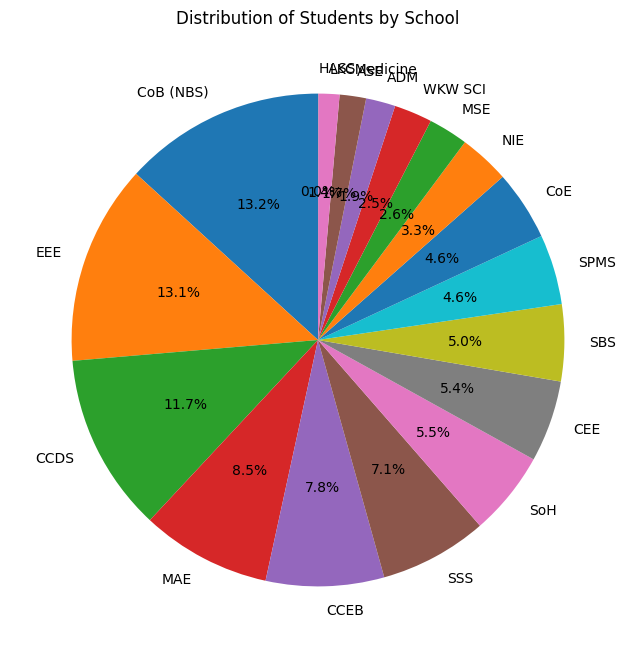

In [1]:
import pandas as pd ### Only for data analysis 
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('records.csv')

# Pie chart for 'School'
plt.figure(figsize=(8, 8))
df['School'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Students by School')
plt.ylabel('')  # Hide the y-label
plt.show()

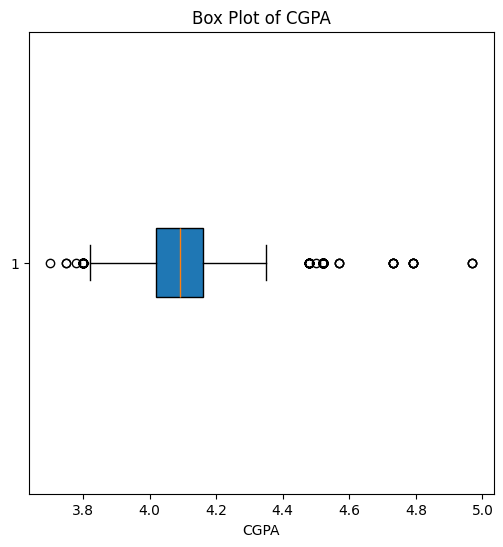

In [6]:
# Box plot for 'CGPA'
plt.figure(figsize=(6, 6))
plt.boxplot(df['CGPA'], vert=False, patch_artist=True)
plt.title('Box Plot of CGPA')
plt.xlabel('CGPA')
plt.show()


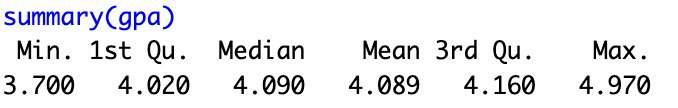

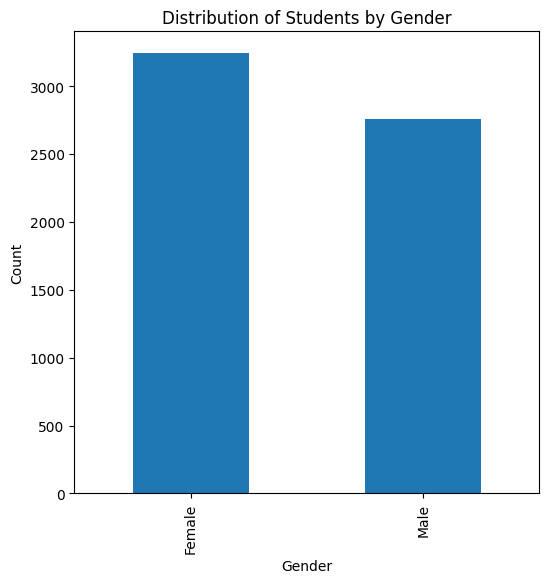

In [7]:
# Bar graph for 'Gender'
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Students by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

The dataset of students reveals significant unevenness across various attributes, such as school affiliation, gender, and CGPA distribution. This imbalance poses a challenge when attempting to form groups with diverse representation using a purely constraint-based approach, as it may lead to impractical or suboptimal groupings. To address these limitations, we opted for a genetic algorithm approach.


# **Planning**

## Genetic Algorithm Approach

### What is a Genetic Algorithm?

A genetic algorithm (GA) is a search heuristic inspired by the process of natural selection. It is used to solve optimization and search problems by mimicking the principles of evolution. GAs operate on a population of potential solutions, applying genetic operators such as selection, crossover, and mutation to evolve the solutions over successive generations.

### Why is it Useful for Our Project?

1. **Optimization**: The primary advantage of using a genetic algorithm is its ability to efficiently search through large solution spaces to find optimal or near-optimal solutions. This is particularly beneficial in our case, where we need to form diverse and balanced teams from a large pool of students.

2. **Flexibility**: GAs can easily adapt to various constraints and objectives. In our project, we have multiple criteria for team formation, including gender diversity, school affiliation, and CGPA balance. The genetic algorithm can be tailored to prioritize these criteria according to our needs.

3. **Robustness**: Genetic algorithms are robust in dealing with complex and dynamic environments. They can explore different regions of the solution space simultaneously, reducing the risk of getting stuck in local optima, which is crucial for our requirement of maintaining balanced team compositions.

### Why We Chose a Genetic Algorithm

Given the complexity of our problem and the limitations of a constraint-based approach, we opted for a genetic algorithm for the following reasons:

- **Scalability**: With 6,000 students to organize, a genetic algorithm can efficiently handle large datasets and generate solutions that meet our diversity criteria.
- **Diversity Maintenance**: GAs naturally promote diversity in solutions, aligning perfectly with our goal of forming teams that reflect a balanced mix of backgrounds and performance levels.
- **Iterative Improvement**: The iterative nature of genetic algorithms allows for continuous improvement of solutions, enabling us to refine team compositions over successive generations until we achieve our desired diversity outcomes.


In [8]:
from mermaid import Mermaid

Mermaid("""

graph TD
    A[Start] --> B[Initialize Population]
    B --> C[Evaluate Fitness]
    C --> D{Termination Condition}
    D -->|Yes| E[Return Best Solution]
    D -->|No| F[Selection]
    F --> G[Crossover]
    G --> B
""")


### Main functions for our algorithm 

- Load data from the CSV file
- Create initial population
- Calculate fitness
- Select parents for crossover
- Perform crossover
- Run the genetic algorithm
- Save groups to CSV


---
# **Implementation**

## Loading Data from the CSV

In [9]:
import random
import os

def load_students_from_csv(file_path):
    students = []
    with open(file_path, 'r') as file:
        next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 6:  # Ensure the line has the correct number of parts
                tutorial_group, student_id, school, name, gender, cgpa = parts
                student = (
                    tutorial_group,
                    student_id,
                    school,
                    name,
                    gender,
                    float(cgpa)  # Convert CGPA to float
                )
                students.append(student)
    return students


*The load_students_from_csv function reads and processes student data from a CSV file. It skips the header, splits each line into six parts (tutorial group, student ID, school, name, gender, CGPA), and converts the CGPA to a float. Each student's data is stored as a tuple in a list, which is then returned for further use in the algorithm.*

## Creating Initial Population

In [10]:
def create_initial_population(students, group_size=5, target_groups=10):
    random.shuffle(students)  # Shuffle the students before grouping
    initial_population = []

    for i in range(0, len(students), group_size):
        group_chunk = students[i:i + group_size]
        if len(group_chunk) == group_size:  
            initial_population.append(group_chunk)

        if len(initial_population) >= target_groups:  # Limit to target groups
            return initial_population
    
    return initial_population[:target_groups]  # Ensure only target groups are returned

*The create_initial_population function forms an initial set of student groups. It first shuffles the list of students to ensure randomness, then divides them into chunks of the specified group_size. Groups are added to the initial population if they meet the group_size and until reaching the specified target_groups. Finally, it returns the initial population with the target number of groups.*

## Creating Fitness Function 

In [11]:

def calculate_variance(values):
    n = len(values)
    mean = sum(values) / n
    variance = sum((x - mean) ** 2 for x in values) / (n - 1)  
    return variance

def individual_fitness_scores(group):
    # Calculate CGPA variance and normalize
    cgpa_values = [student[5] for student in group]
    cgpa_variance = calculate_variance(cgpa_values)
    normalized_cgpa_variance = min(cgpa_variance / 0.177656, 1)  

    # Calculate gender variance and normalize
    gender_values = [1 if student[4] == 'Female' else 0 for student in group]
    gender_variance = calculate_variance(gender_values)
    max_gender_variance = 0.24  # Set based on your realistic limits
    normalized_gender_variance = (gender_variance) / max_gender_variance

    # Calculate school diversity and normalize
    schools = [student[2] for student in group]
    unique_schools = len(set(schools))
    normalized_school_diversity = unique_schools / 5

    return normalized_cgpa_variance, normalized_gender_variance, normalized_school_diversity

def fitness_func(group):
    # Get individual normalized scores
    normalized_cgpa_variance, normalized_gender_variance, normalized_school_diversity = individual_fitness_scores(group)
    
    # Calculate overall fitness score as the average of the normalized values
    fitness_score = ((normalized_cgpa_variance + normalized_gender_variance + normalized_school_diversity) / 3) * 100
    return fitness_score

The fitness function evaluates the diversity and balance of each group using three main criteria:

CGPA Variance: The variance in CGPA values within a group is calculated and normalized against a maximum value of 0.177656, providing a score for academic balance.

Gender Variance: Gender diversity is assessed by calculating variance and normalizing the score based on ideal distributions, with a maximum variance of 0.24 representing balanced gender representation (e.g., three males and two females or vice versa).

School Diversity: The number of unique schools represented within each group is normalized, promoting variety in academic backgrounds, with the maximum diversity represented by five unique schools. (The ideal situtaion)

Each criterion is scored individually and normalized, and the overall fitness score for the group is calculated as the average of these three scores, expressed as a percentage. 

## Creating a Selection Proccess

In [12]:
def select_parents(population):
    fitness_scores = [(group, fitness_func(group)) for group in population]
    # Sort by fitness score
    fitness_scores.sort(key=lambda x: x[1])
    
    # Select most fit (last) and least fit (first)
    least_fit = fitness_scores[0][0]
    most_fit = fitness_scores[-1][0]

    return most_fit, least_fit

The select_parents function evaluates the fitness of groups within the population by calculating their scores based on diversity and balance criteria. It identifies the least fit group, which may require adjustments to improve diversity, and the most fit group, which represents successful configurations. This selection process facilitates the creation of offspring groups that embody moderate diversity, thus promoting effective team dynamics while avoiding extremes.

## Creating a Crossover Method

In [13]:
def crossover(parent1, parent2):
    # Get individual fitness scores for CGPA and gender for each parent group
    cgpa_variance_parent1, gender_variance_parent1, _ = individual_fitness_scores(parent1)
    
    # Determine the sorting strategy based on which variance is smaller
    if gender_variance_parent1 < cgpa_variance_parent1:
        # Sort one parent by ascending CGPA, the other by descending CGPA
        parent1_sorted = sorted(parent1, key=lambda x: x[5])  # ascending by CGPA
        parent2_sorted = sorted(parent2, key=lambda x: x[5], reverse=True)  # descending by CGPA
    else:
        # Sort one parent by ascending gender, the other by descending gender
        parent1_sorted = sorted(parent1, key=lambda x: x[4])  # ascending by gender
        parent2_sorted = sorted(parent2, key=lambda x: x[4], reverse=True)  # descending by gender

    # Perform crossover: swap students at even indices
    child1 = parent1_sorted[:]
    child2 = parent2_sorted[:]
    for i in range(0, len(parent1), 2):  # Swap students at even indices
        child1[i], child2[i] = child2[i], child1[i]
    
    return child1, child2

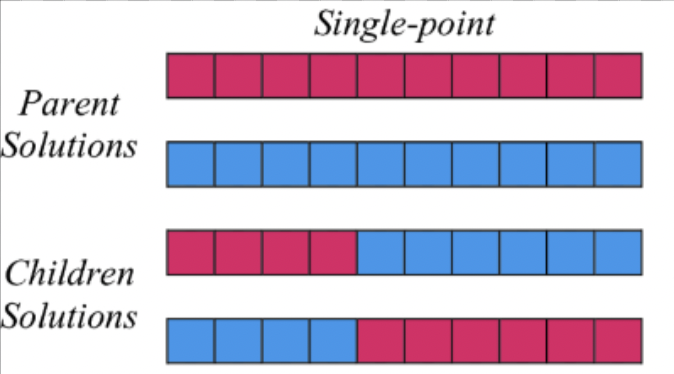

Source: Mirjalili, S., Dong, J. S., & Lewis, A. (2020). Nature-inspired optimizers: Theories, literature reviews and applications. Springer. 



The crossover function creates two new child groups from two parent groups to enhance diversity and balance.

Fitness Evaluation: It starts by calculating individual fitness scores for CGPA and gender variances for parent1.

Sorting: If the individual fitness score for gender is lower than that of CGPA, it sorts parent1 by ascending CGPA and parent2 by descending CGPA. If the gender  is higher, it sorts parent1 by ascending gender and parent2 by descending gender. This ensures that the crossover is informed by which aspect (CGPA or gender) needs balancing.

Crossover Process: The function generates child groups by swapping students at even indices, mixing attributes from both parents to create diverse combinations.

Example:

Parent 1: (0, 0, 0, 0, 1) [4 males, 1 female]

Parent 2: (0, 1, 1, 1, 1) [1 male, 4 females]

Sorted Parent 1: (0, 0, 0, 0, 1)

Sorted Parent 2: (1, 1, 1, 1, 0)

After swapping even students:

Child 1: (0, 1, 0, 1, 1) [2 males, 3 females]

Child 2: (1, 0, 1, 0, 0) [3 males, 2 females]


## Genetic Algorithm Loop

In [14]:
def run_genetic_algorithm_for_group(students, target_groups=10, generations=1000):
    population = create_initial_population(students, group_size=5, target_groups=target_groups)
    
    highest_avg_fitness = 0  # Variable to keep track of the highest average fitness score
    best_generation_index = 0  # Index of the generation with the highest average fitness score
    best_population = None  # Variable to store the best population
    best_generation_info = {}  # To store best generation info for this tutorial group

    for generation in range(generations):
        new_population = []
        
        while len(new_population) < target_groups:
            parent1, parent2 = select_parents(population)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(child1)
            new_population.append(child2)

            # Remove parents from the population
            population.remove(parent1)
            population.remove(parent2)
        
        # Calculate average fitness score for the generation
        avg_fitness_score = sum(fitness_func(group) for group in new_population) / len(new_population)
        
        # Check if this generation has the highest average fitness
        if avg_fitness_score > highest_avg_fitness:
            highest_avg_fitness = avg_fitness_score
            best_generation_index = generation + 1  # Store generation index (1-based)
            best_population = new_population.copy()  # Store a copy of the best population
            best_generation_info = {
                "generation": best_generation_index,
                "average_fitness": highest_avg_fitness,
                "fitness_scores": [fitness_func(group) for group in new_population]
            }

        population = new_population  # Set the new population for the next generation
    
    return best_generation_info, best_population


The run_genetic_algorithm_for_group function implements a genetic algorithm to form balanced student groups over a specified number of generations.

- Initialization: It starts by creating an initial population of groups from the given student list, each containing a specified number of students.

- Main Loop: The function runs for a set number of generations. In each generation:

    - Parent Selection: Two parents are selected based on their fitness scores, promoting diversity in the population.
    - Crossover: The selected parents undergo crossover to produce two children, mixing their attributes to enhance diversity.
    - Population Management: The parents are removed from the population to prevent repetition, and the new children are added to fresh population.


- Fitness Evaluation: After forming the new population, the function calculates the average fitness score across all groups.

- Best Population Tracking: It checks if the current generation's average fitness score exceeds the highest recorded score. If so, it updates the best population information, storing the generation index, average fitness, and individual fitness scores of the groups.

Output: At the end of the specified generations, the function returns the details of the best generation found and the corresponding population, allowing for evaluation of the most balanced student groups achieved during the process.

## Export groups into CSV

In [15]:
def save_groups_to_csv(groups, file_path='final_groups.csv'):
    file_exists = os.path.isfile(file_path)  # Check if the file already exists
    with open(file_path, 'a') as file:  # Open the file in append mode
        if not file_exists:
            # Write the header only if the file does not exist
            file.write('Group Number,Tutorial Group,Student ID,School,Name,Gender,CGPA\n')

        for group_number, group in enumerate(groups, start=1):
            for student in group:
                # Convert to list, add group number, and convert back to tuple for saving
                student_list = list(student)  
                student_list.insert(0, group_number)  # Add group number at the start
                student_row = ','.join(map(str, student_list)) + '\n'
                file.write(student_row)  # Write the row to the file


The save_groups_to_csv function saves student group data to a CSV file, ensuring structured and accessible output.

File Check: It checks if the specified CSV file exists to determine if the header row should be written.

Opening File: The file is opened in append mode ('a'), allowing new data to be added without overwriting existing content.

Header Writing: If the file does not exist, it writes the header with column titles: "Group Number," "Tutorial Group," "Student ID," "School," "Name," "Gender," and "CGPA."

Data Writing: The function iterates over the groups, assigns a group number to each student, converts their data to a list (inserting the group number), and writes it as a comma-separated string in the CSV file.

## Main func

In [ ]:

def main():
    # Load students from the CSV file
    students = load_students_from_csv('records.csv')
    
    # Group students by their tutorial groups
    tutorial_groups = {}
    for student in students:
        tutorial_group = student[0]
        if tutorial_group not in tutorial_groups:
            tutorial_groups[tutorial_group] = []
        tutorial_groups[tutorial_group].append(student)

    all_best_population = []  # List to hold best populations for all groups

    # Run the genetic algorithm for each tutorial group
    for group_name, group_students in tutorial_groups.items():
        best_generation_info, best_population = run_genetic_algorithm_for_group(group_students)
        
        # Append the best population for the current tutorial group
        all_best_population.extend(best_population)  # Flatten the population

        print(f'Tutorial Group: {group_name}')
        print(f'Best Generation: {best_generation_info["generation"]}')
        print(f'Average Fitness: {best_generation_info["average_fitness"]:.2f}')
        print(f'Fitness Scores: {best_generation_info["fitness_scores"]}')
        print()  # Print an extra newline for better spacing

    # Save all best groups to CSV
    save_groups_to_csv(all_best_population)  # Use the collected best populations

if __name__ == '__main__':
    main()

The main() function orchestrates the process of loading student data, organizing students into tutorial groups using dictionary, running the genetic algorithm to optimize group compositions, and saving the results to a CSV file. 

---

# Evaluating the algorithm 

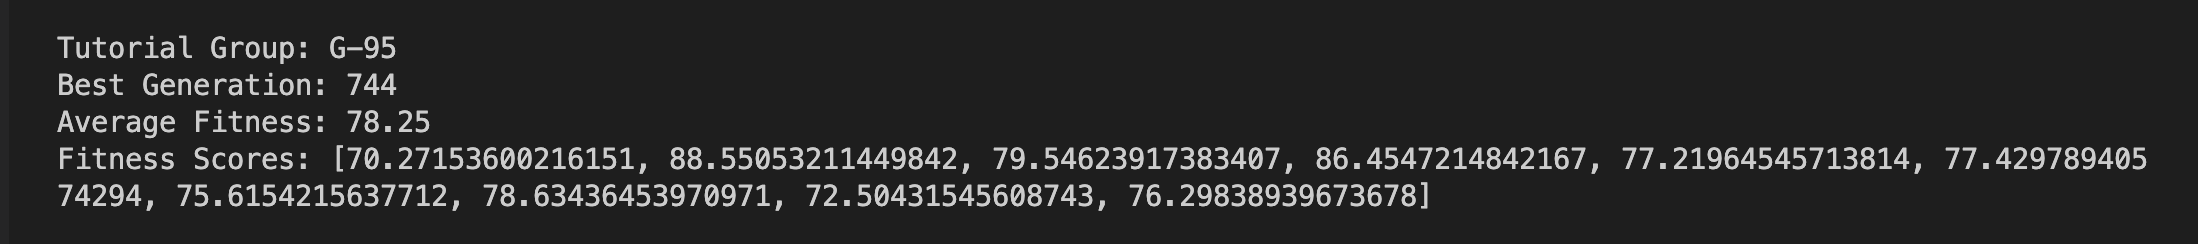

**Team 1: (Fitness Score 70.27)**

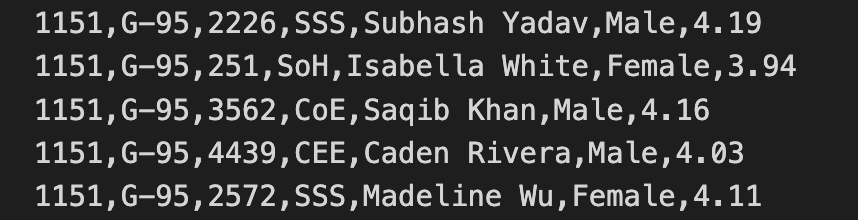

**Team 2: (Fitness Score 88.55)**

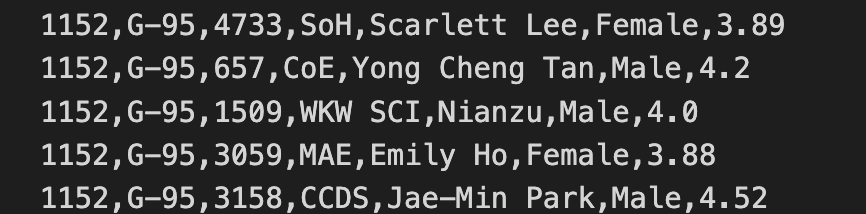


---

# Challenges 



Throughout the development of our genetic algorithm for creating diverse student groups, we encountered several significant challenges that required us to modify our approach extensively.

- Initially, we adopted a "survival of the fittest" strategy, where groups with higher fitness scores had a greater probability of being selected to create new groups. However, this led to an issue where the final generation contained many of the same students in multiple groups, as the same parents were frequently chosen. To address this, we abandoned this idea and instead implemented a mechanism to eliminate selected parents from the population after they were used, ensuring more diverse group composition.

- Additionally, our original design involved having two parents produce one child, similar to traditional genetic algorithms. This approach, however, resulted in a shrinking population and frequent out-of-index errors. To mitigate this problem, we modified the algorithm so that two parents would generate two children instead. This adjustment not only maintained the population size but also improved overall functionality and stability, allowing for a more effective evolution of diverse groups.

# Strengths

- Modular Approach: One of our key strengths is the modular structure of our approach.  This modularity allows for flexible customization and easy debugging, enabling us to make specific modifications without impacting the entire algorithm. It also enhances scalability, as modules can be updated or expanded independently as needed.

- Modified Genetic Algorithm: We implemented a modified genetic algorithm tailored specifically for our grouping objective.This adaptation ensures that the algorithm aligns closely with our goal, focusing its optimization capabilities on creating effective and well-balanced groups, thus improving the quality and relevance of the grouping results. 

- Effective Fitness Function: Our fitness function is designed to evaluate the diversity of the groups thoroughly. By emphasizing diversity in the evaluation process, the algorithm effectively generates groups that are varied and balanced, enhancing the overall effectiveness of the grouping solution.

- Another strength of our code is its scalability. By taking team size and number of teams as parameters, it allows for easy adjustments to the group configurations. Any changes in the team structure can be made simply by modifying these variables, making the code adaptable to different requirements without needing major modifications.

# Limitations



*Our approach using a genetic algorithm to create diverse student groups can be memory and time-intensive, particularly with 1000 generations. This leads to a trade-off between resource efficiency and the level of diversity achieved. While more generations can improve diversity, they also increase computational demands. Therefore, we can adjust the number of generations based on the desired balance between these factors, allowing for more efficient use of resources without sacrificing group diversity.*

---

# Conclusion 

In conclusion, the development of the genetic algorithm for creating diverse student groups required iterative problem-solving and refinement. Initially, challenges such as repeated students in groups, population shrinkage, and high computational demands impacted the algorithm’s effectiveness and stability. By systematically addressing these issues—excluding previously used parents, maintaining population size by producing two children per pair, and balancing the number of generations to optimize resources—the algorithm evolved into a more robust and efficient tool. Ultimately, this approach effectively achieves the goal of forming balanced and inclusive student groups, while maintaining flexibility to balance diversity with computational efficiency.